In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
(_x_train, _y_train), (_x_test, _y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
_x_train, _x_test = _x_train[..., np.newaxis]/255.0, _x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(_x_train))
print("Number of original test examples:", len(_x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

Number of filtered training examples: 12049
Number of filtered test examples: 1968
True


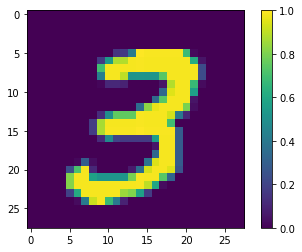

In [4]:
x_train, y_train = filter_36(_x_train, _y_train)
x_test, y_test = filter_36(_x_test, _y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
_ = plt.colorbar()

True


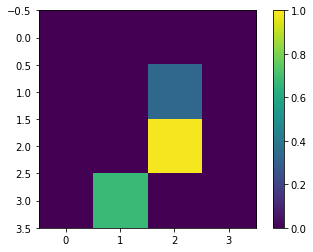

In [5]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
_ = plt.colorbar()

In [6]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
        orig_x[tuple(x.flatten())] = x
        mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
        x = orig_x[flatten_x]
        labels = mapping[flatten_x]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(next(iter(labels)))
        else:
            # Throw out images that match more than one label.
            pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [7]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [8]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [9]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


In [10]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


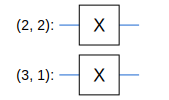

In [11]:
SVGCircuit(x_train_circ[0])

In [12]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [13]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [14]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout) ** symbol)

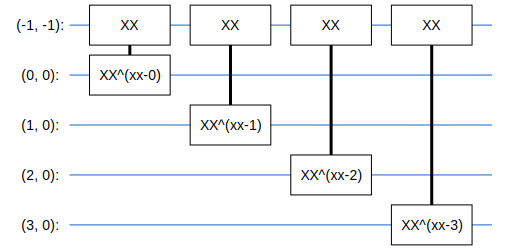

In [15]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [16]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

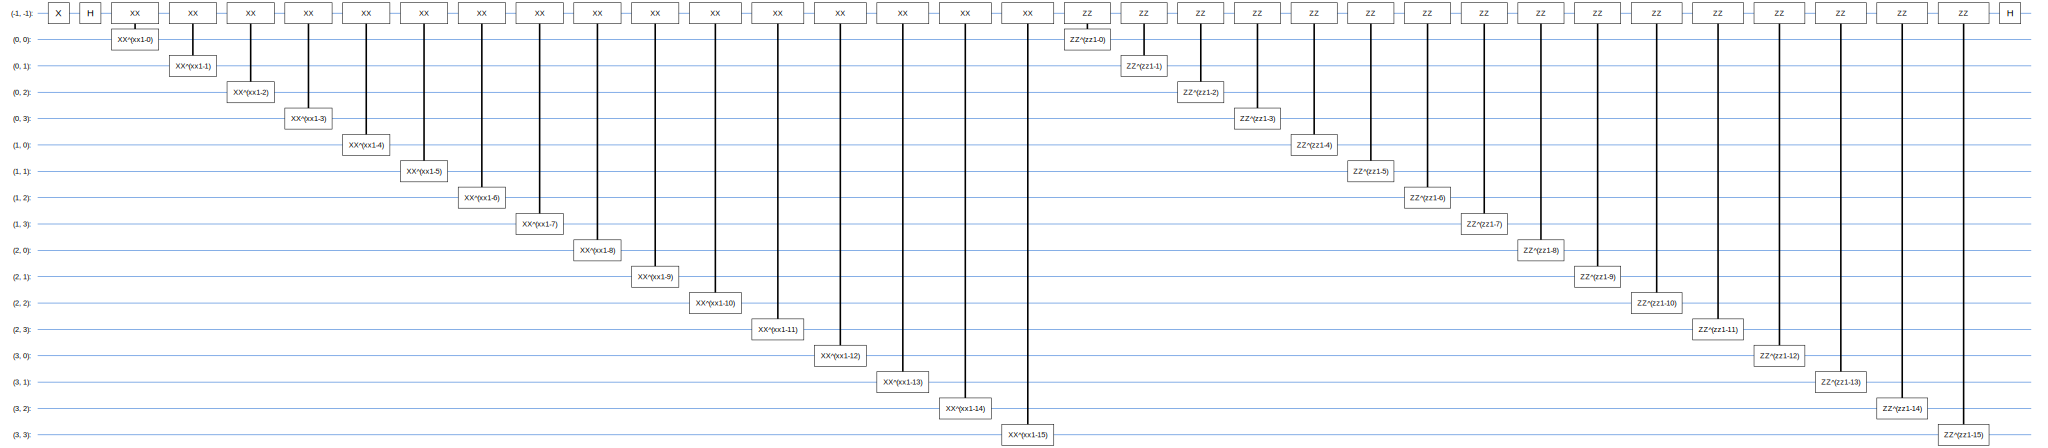

In [17]:
model_circuit, model_readout = create_quantum_model()
SVGCircuit(model_circuit)

In [18]:
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.get_weights()[0]

array([2.7640305 , 2.0193322 , 2.9840376 , 3.6442254 , 3.1995244 ,
       2.0702531 , 3.8027804 , 0.20872027, 1.1643169 , 1.8303604 ,
       2.989003  , 5.038977  , 0.9609656 , 4.6591597 , 4.190578  ,
       0.5626264 , 3.6648366 , 2.0212603 , 2.5793931 , 3.7494693 ,
       0.61948407, 3.9657943 , 4.7803607 , 2.925076  , 2.2498353 ,
       4.721987  , 1.2780899 , 2.3143547 , 4.586108  , 4.2541137 ,
       6.0069923 , 2.2070577 ], dtype=float32)

In [21]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [22]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [23]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])


EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)


x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 164s 505ms/step - loss: 0.8790 - hinge_accuracy: 0.6033 - val_loss: 0.5556 - val_hinge_accuracy: 0.8226
Epoch 2/3
324/324 [==============================] - 147s 455ms/step - loss: 0.4320 - hinge_accuracy: 0.8234 - val_loss: 0.3618 - val_hinge_accuracy: 0.8952
Epoch 3/3
62/62 [==============================] - 5s 73ms/step - loss: 0.3395 - hinge_accuracy: 0.9042


In [24]:
model.get_weights()[0]

array([2.9999998e+00, 2.0000072e+00, 3.0000098e+00, 3.9241199e+00,
       3.0000002e+00, 1.9999995e+00, 3.9999330e+00, 2.2132589e-07,
       1.0000044e+00, 1.9999995e+00, 3.0000017e+00, 5.0000000e+00,
       1.0000000e+00, 4.9527907e+00, 4.0969687e+00, 1.0000002e+00,
       3.7868745e+00, 1.9029781e+00, 2.0018985e+00, 3.9568377e+00,
       7.3495442e-01, 4.0863853e+00, 5.0332656e+00, 2.8882215e+00,
       2.1084647e+00, 4.6785941e+00, 1.3512025e+00, 2.0798459e+00,
       4.8490386e+00, 4.0547895e+00, 6.0068350e+00, 2.2392592e+00],
      dtype=float32)

In [25]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


f_model = create_fair_classical_model()
f_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [26]:
f_model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = f_model.evaluate(x_test_bin, y_test)

Epoch 1/20
81/81 - 1s - loss: 0.8629 - accuracy: 0.4393 - val_loss: 0.7806 - val_accuracy: 0.4223 - 508ms/epoch - 6ms/step
Epoch 2/20
81/81 - 0s - loss: 0.7526 - accuracy: 0.4869 - val_loss: 0.6909 - val_accuracy: 0.4741 - 91ms/epoch - 1ms/step
Epoch 3/20
81/81 - 0s - loss: 0.6550 - accuracy: 0.5877 - val_loss: 0.6076 - val_accuracy: 0.5874 - 91ms/epoch - 1ms/step
Epoch 4/20
81/81 - 0s - loss: 0.5727 - accuracy: 0.6904 - val_loss: 0.5423 - val_accuracy: 0.6636 - 102ms/epoch - 1ms/step
Epoch 5/20
81/81 - 0s - loss: 0.5089 - accuracy: 0.7345 - val_loss: 0.4904 - val_accuracy: 0.7652 - 113ms/epoch - 1ms/step
Epoch 6/20
81/81 - 0s - loss: 0.4584 - accuracy: 0.7819 - val_loss: 0.4473 - val_accuracy: 0.7698 - 91ms/epoch - 1ms/step
Epoch 7/20
81/81 - 0s - loss: 0.4181 - accuracy: 0.7853 - val_loss: 0.4135 - val_accuracy: 0.7718 - 93ms/epoch - 1ms/step
Epoch 8/20
81/81 - 0s - loss: 0.3866 - accuracy: 0.8006 - val_loss: 0.3862 - val_accuracy: 0.8013 - 98ms/epoch - 1ms/step
Epoch 9/20
81/81 - 0s

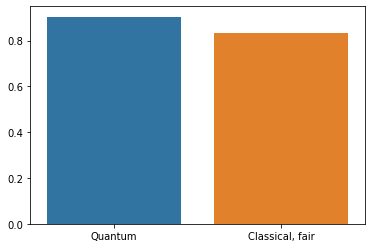

In [27]:
qnn_accuracy = qnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, fair"],
            [qnn_accuracy, fair_nn_accuracy])